In [137]:
library(tidyverse) # metapackage of all tidyverse packages
library(tidymodels)
library(dplyr)
library(yardstick)


set.seed(200)

In [138]:
cross_sectional <- read_csv("data/oasis_cross-sectional.csv")
longitudinal <- read_csv("data/oasis_longitudinal.csv")

head(cross_sectional)
head(longitudinal)

Rows: 436 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (4): ID, M/F, Hand, Delay
dbl (8): Age, Educ, SES, MMSE, CDR, eTIV, nWBV, ASF

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 373 Columns: 15
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (5): Subject ID, MRI ID, Group, M/F, Hand
dbl (10): Visit, MR Delay, Age, EDUC, SES, MMSE, CDR, eTIV, nWBV, ASF

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
OAS1_0001_MR1,F,R,74,2,3,29,0.0,1344,0.743,1.306,N/A
OAS1_0002_MR1,F,R,55,4,1,29,0.0,1147,0.810,1.531,N/A
OAS1_0003_MR1,F,R,73,4,3,27,0.5,1454,0.708,1.207,N/A
OAS1_0004_MR1,M,R,28,NA,NA,NA,NA,1588,0.803,1.105,N/A
OAS1_0005_MR1,M,R,18,NA,NA,NA,NA,1737,0.848,1.010,N/A
OAS1_0006_MR1,F,R,24,NA,NA,NA,NA,1131,0.862,1.551,N/A


Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2,27,0.0,1987,0.696,0.883
OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2,30,0.0,2004,0.681,0.876
OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NA,23,0.5,1678,0.736,1.046
OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NA,28,0.5,1738,0.713,1.010
OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NA,22,0.5,1698,0.701,1.034
OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3,28,0.0,1215,0.710,1.444


# Defining Terminology

| Abreviation | Term | Definition | Possible Values |
|-------------|------|------------|-----------------|
| CDR  | Clinical Dementia Rating | Stages dementia, including Alzheimer disease, in elderly patients. | 0.5, 1, 2, 3 |
| eTIV  | estimated Total Intracranial Volume | The volume within the cranium, including the brain, meninges, and CSF. | - |
| nWBV  | normalized Whole Brain Volume | The percentage of the intracranial cavity occupied by brain. **Important for Alzheimers** | 0-1 |
| ASF  | Atlas Scaling Factor | The volume-scaling factor required to match each individual to the atlas target. | - |
| MMSE  | Mini Mental Health State Examination | Test used by clinicians to assess cognitive function and screen for cognitive impairment, including dementia. | 0-30 |



In [139]:


cross_sectional <- cross_sectional |>
    rename(EducationLevel = Educ) |>
    select(-Delay)

longitudinal <- longitudinal |>
    group_by(`Subject ID`) |>
    slice_sample(n = 1) |>
    ungroup() |>
    rename(ID = `MRI ID`) |>
    mutate(EducationLevel = if_else(EDUC < 12, 1, 
                    if_else(EDUC < 13, 2, 
                    if_else(EDUC < 16, 3, 
                    if_else(EDUC < 17, 4, 5))))) |>
    select(-`Subject ID`, -Group, -`MR Delay`, -Visit, -EDUC)

head(cross_sectional)
nrow(cross_sectional)
head(longitudinal)
nrow(longitudinal)

ID,M/F,Hand,Age,EducationLevel,SES,MMSE,CDR,eTIV,nWBV,ASF
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OAS1_0001_MR1,F,R,74,2,3,29,0.0,1344,0.743,1.306
OAS1_0002_MR1,F,R,55,4,1,29,0.0,1147,0.810,1.531
OAS1_0003_MR1,F,R,73,4,3,27,0.5,1454,0.708,1.207
OAS1_0004_MR1,M,R,28,NA,NA,NA,NA,1588,0.803,1.105
OAS1_0005_MR1,M,R,18,NA,NA,NA,NA,1737,0.848,1.010
OAS1_0006_MR1,F,R,24,NA,NA,NA,NA,1131,0.862,1.551


[1] 436

ID,M/F,Hand,Age,SES,MMSE,CDR,eTIV,nWBV,ASF,EducationLevel
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OAS2_0001_MR2,M,R,88,2,30,0.0,2004,0.681,0.876,3
OAS2_0002_MR2,M,R,76,NA,28,0.5,1738,0.713,1.010,2
OAS2_0004_MR1,F,R,88,3,28,0.0,1215,0.710,1.444,5
OAS2_0005_MR3,M,R,85,4,30,0.0,1699,0.705,1.033,2
OAS2_0007_MR1,M,R,71,NA,28,0.5,1357,0.748,1.293,4
OAS2_0008_MR2,F,R,95,2,29,0.0,1257,0.703,1.396,3


[1] 150

In [140]:
oasis <- rbind(longitudinal, cross_sectional)

head(oasis)
nrow(oasis)

ID,M/F,Hand,Age,SES,MMSE,CDR,eTIV,nWBV,ASF,EducationLevel
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OAS2_0001_MR2,M,R,88,2,30,0.0,2004,0.681,0.876,3
OAS2_0002_MR2,M,R,76,NA,28,0.5,1738,0.713,1.010,2
OAS2_0004_MR1,F,R,88,3,28,0.0,1215,0.710,1.444,5
OAS2_0005_MR3,M,R,85,4,30,0.0,1699,0.705,1.033,2
OAS2_0007_MR1,M,R,71,NA,28,0.5,1357,0.748,1.293,4
OAS2_0008_MR2,F,R,95,2,29,0.0,1257,0.703,1.396,3


[1] 586

In [141]:
oasis <- oasis |>
    rename(Sex = `M/F`) |>
    mutate(Sex = as_factor(Sex),
           Hand = as_factor(Hand),
           EducationLevel = as_factor(EducationLevel)) 
    

head(oasis)

ID,Sex,Hand,Age,SES,MMSE,CDR,eTIV,nWBV,ASF,EducationLevel
<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
OAS2_0001_MR2,M,R,88,2,30,0.0,2004,0.681,0.876,3
OAS2_0002_MR2,M,R,76,NA,28,0.5,1738,0.713,1.010,2
OAS2_0004_MR1,F,R,88,3,28,0.0,1215,0.710,1.444,5
OAS2_0005_MR3,M,R,85,4,30,0.0,1699,0.705,1.033,2
OAS2_0007_MR1,M,R,71,NA,28,0.5,1357,0.748,1.293,4
OAS2_0008_MR2,F,R,95,2,29,0.0,1257,0.703,1.396,3


# Summary

In [142]:
count(oasis, Sex)
count(oasis, Hand)

summarize(oasis, mean_age = mean(Age))
count(oasis, SES)

Sex,n
<fct>,<int>
M,230
F,356


Hand,n
<fct>,<int>
R,586


mean_age
<dbl>
57.94539


SES,n
<dbl>,<int>
1,83
2,107
3,83
4,79
5,6
NA,228


# Finishing Cleaning

In [143]:
dementia <- oasis |>
    mutate(Dementia = as_factor(CDR != 0)) |>
    mutate(HighlyEducated = EducationLevel == 5) |>
    select(-ID, -Hand, -eTIV, -ASF, -MMSE) |>
    drop_na()

head(dementia)
count(dementia, Dementia)
nrow(dementia)

Sex,Age,SES,CDR,nWBV,EducationLevel,Dementia,HighlyEducated
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<lgl>
M,88,2,0.0,0.681,3,FALSE,FALSE
F,88,3,0.0,0.710,5,FALSE,TRUE
M,85,4,0.0,0.705,2,FALSE,FALSE
F,95,2,0.0,0.703,3,FALSE,FALSE
M,69,2,0.5,0.791,2,TRUE,FALSE
F,68,3,0.5,0.752,2,TRUE,FALSE


Dementia,n
<fct>,<int>
FALSE,212
TRUE,146


[1] 358

In [144]:

dementia_split <- initial_split(dementia, prop = 0.75, strata = Dementia)
dementia_train <- training(dementia_split)
dementia_test <- testing(dementia_split)

nrow(dementia_train)
nrow(dementia_test)

[1] 268

[1] 90

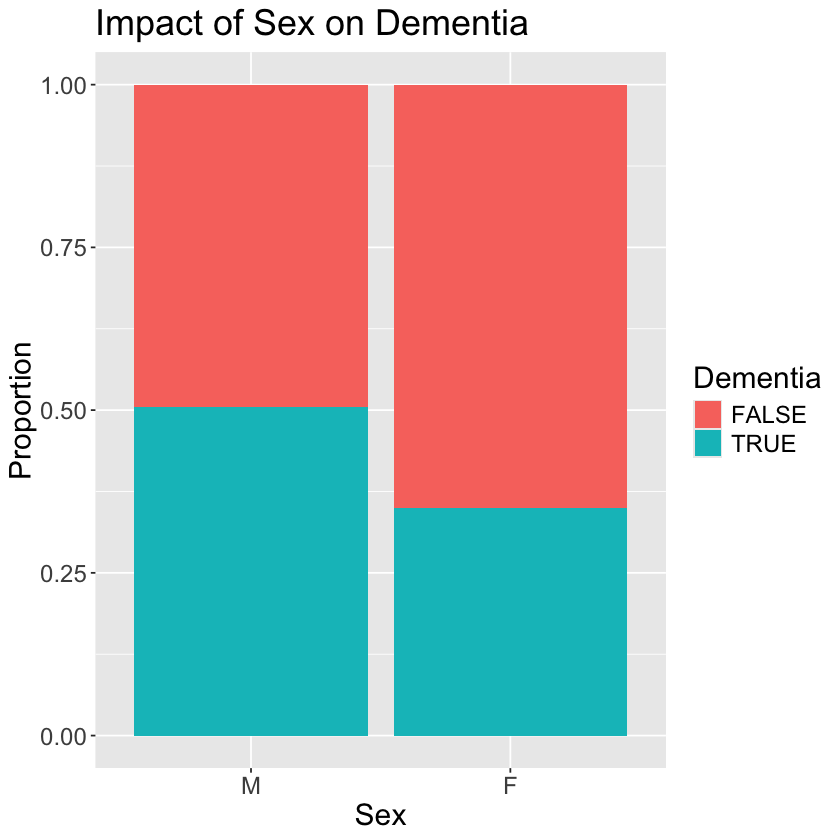

In [145]:
ggplot(dementia_train, aes(x = Sex, fill = Dementia)) +
    geom_bar(position = "fill") +
    labs(title = "Impact of Sex on Dementia", y = "Proportion") +
    theme(text = element_text(size = 18))

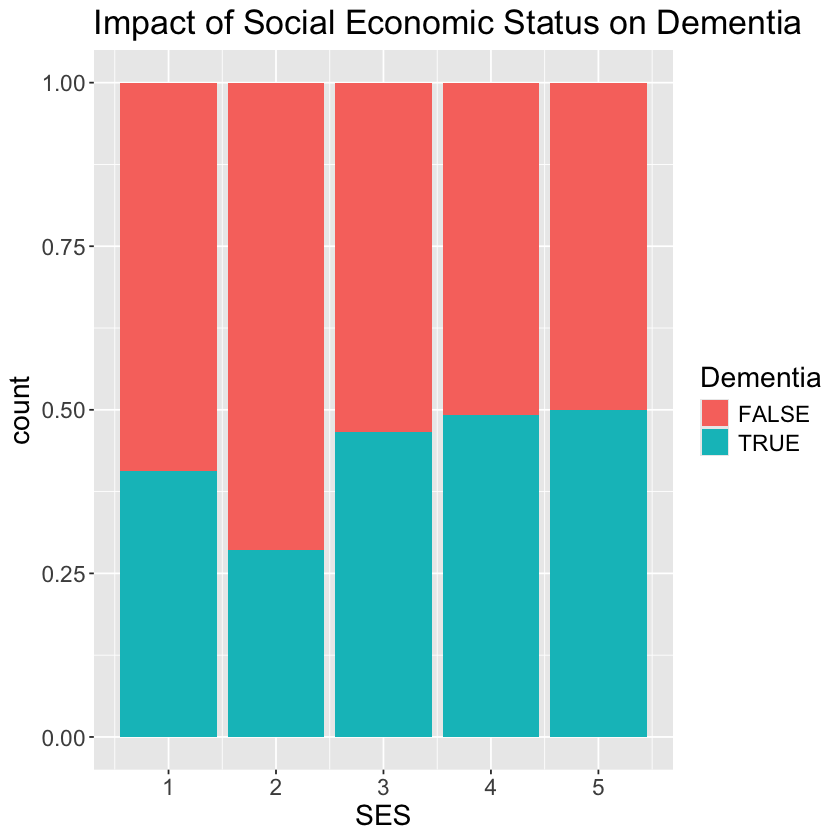

In [164]:
ggplot(dementia_train, aes(x = SES, fill = Dementia)) +
    geom_bar(position = "fill") +
    labs(title = "Impact of Social Economic Status on Dementia") +
    theme(text = element_text(size = 17))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


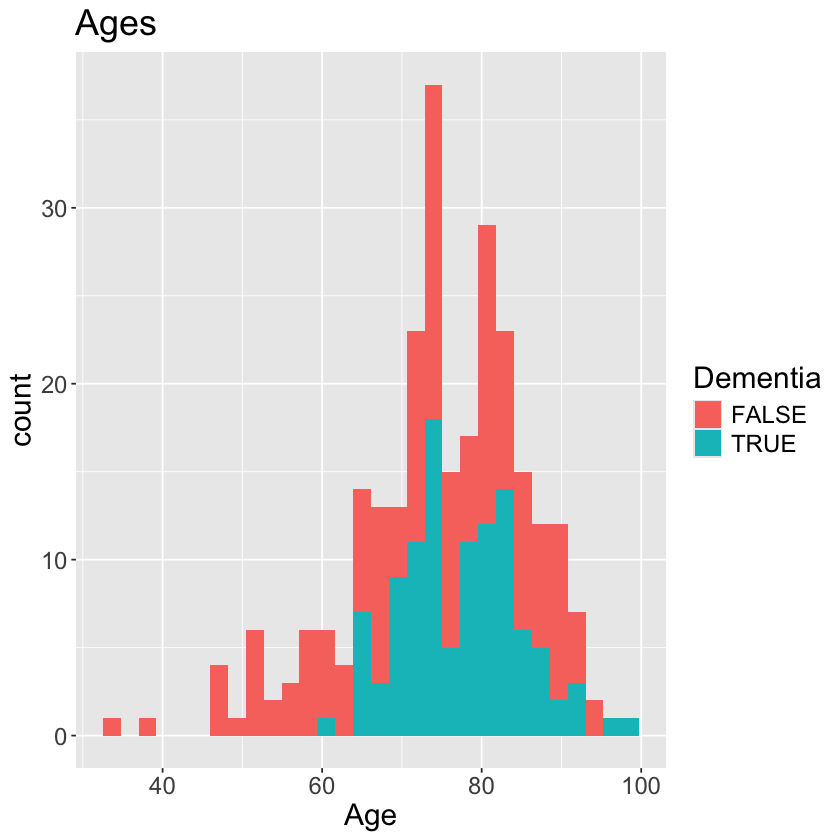

In [147]:
ggplot(dementia_train, aes(x = Age, fill = Dementia)) +
    geom_histogram() +
    labs(title = "Ages") +
    theme(text = element_text(size = 18))

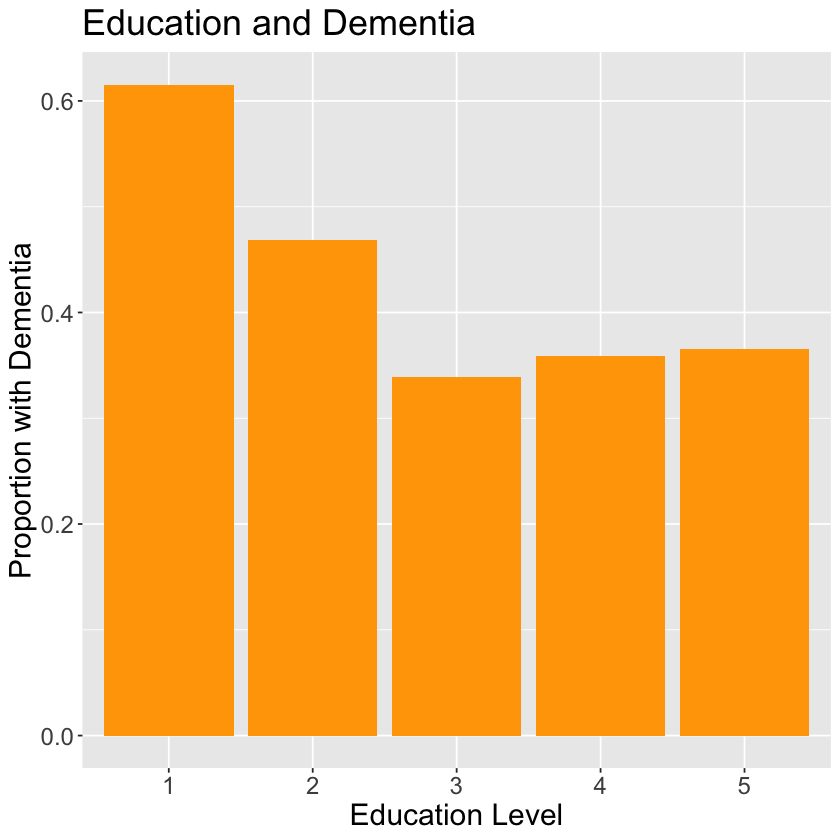

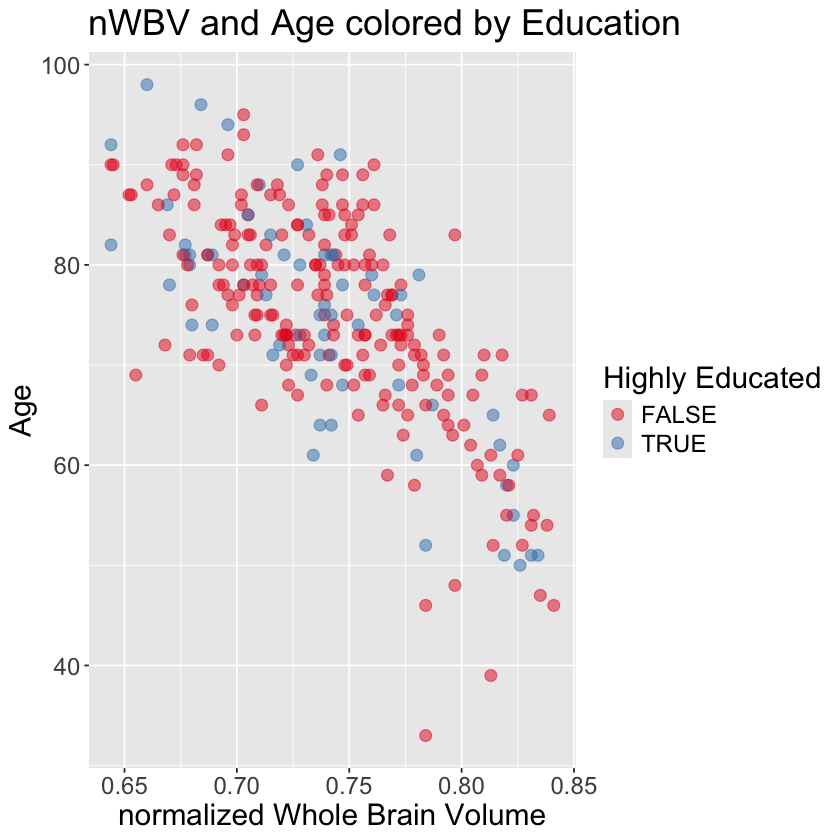

In [148]:
grouped_education <- dementia_train |>
    group_by(EducationLevel) |>
    summarise(PropDementia = mean(Dementia == TRUE))

ggplot(grouped_education, aes(x = EducationLevel, y = PropDementia)) +
    geom_bar(stat = "identity", fill = "orange") +
    labs(x = "Education Level", y = "Proportion with Dementia", title = "Education and Dementia") +
    theme(text = element_text(size = 18))

ggplot(dementia_train, aes(x = nWBV, y = Age, color = HighlyEducated)) +
    geom_point(size = 3, alpha = 0.5) + 
    labs(x = "normalized Whole Brain Volume", color = "Highly Educated", title = "nWBV and Age colored by Education") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set1") 

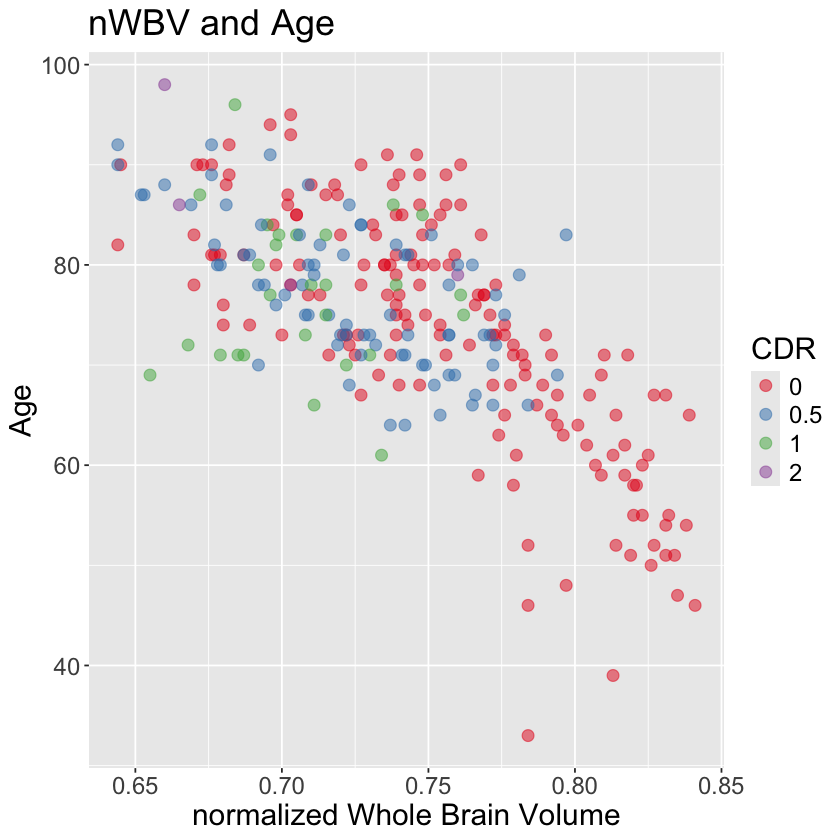

In [149]:
ggplot(dementia_train, aes(x = nWBV, y = Age, color = as_factor(CDR))) +
    geom_point(size = 3, alpha = 0.5) + 
    labs(x = "normalized Whole Brain Volume", color = "CDR", title = "nWBV and Age") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set1") 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


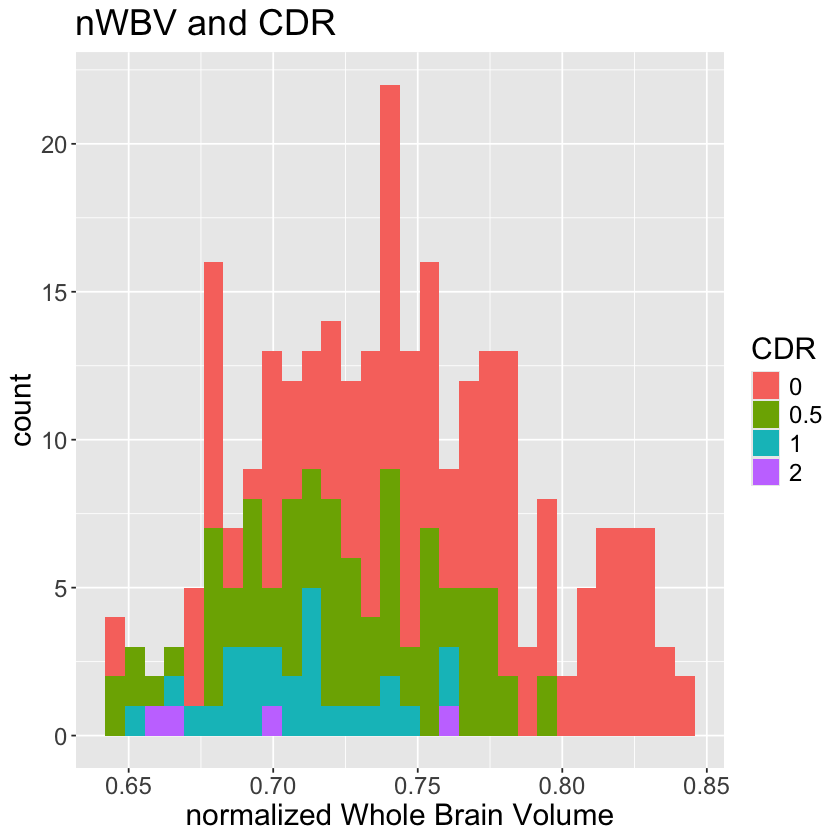

In [150]:
ggplot(dementia_train, aes(x = nWBV, fill = as_factor(CDR))) +
    geom_histogram() + 
    labs(x = "normalized Whole Brain Volume", fill = "CDR", title = "nWBV and CDR") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set1") 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


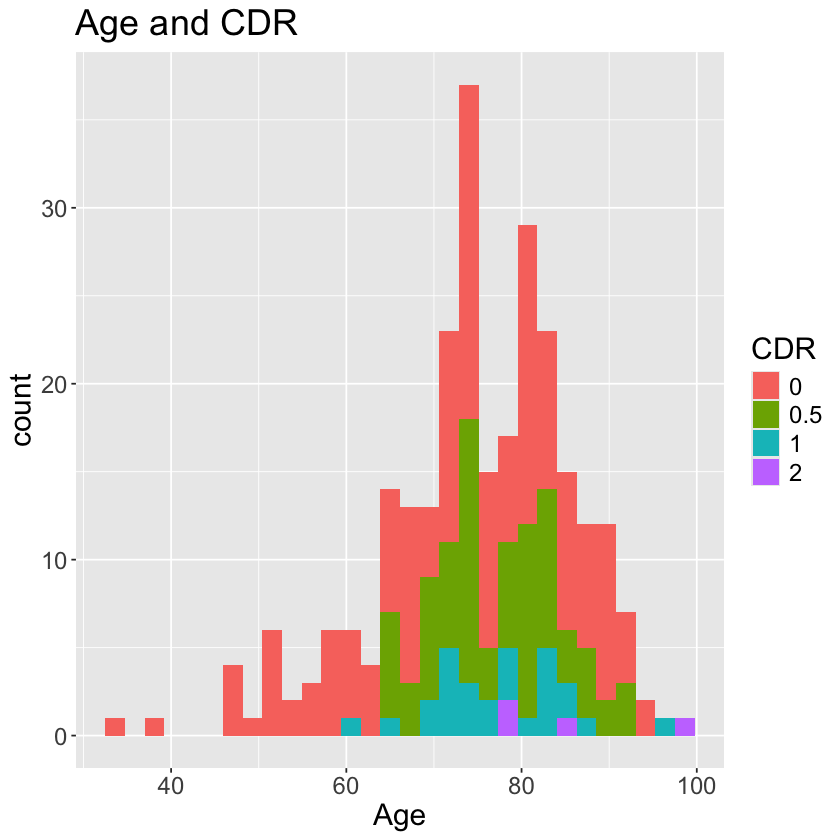

In [151]:
ggplot(dementia_train, aes(x = Age, fill = as_factor(CDR))) +
    geom_histogram() + 
    labs(x = "Age", fill = "CDR", title = "Age and CDR") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set1") 

# Creating the Model

### Classification Using KNN

In [152]:
dementia_vfold <- vfold_cv(dementia_train, v = 5, strata = Dementia)


grid <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

dementia_metrics <- metric_set(accuracy, recall, precision, roc_auc)


dementia_recipe <- recipe(Dementia ~ Age + nWBV + HighlyEducated, data = dementia_train) |>
    step_mutate(HighlyEducated = as.numeric(HighlyEducated)) |>
    step_normalize(all_predictors())

knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(dementia_recipe) |>
    add_model(knn_tune_spec) |>
    tune_grid(resamples = dementia_vfold, grid = grid, 
        metrics = dementia_metrics) |>
    collect_metrics() |>
    filter(.metric == "accuracy" | .metric == "recall" | .metric == "precision") |>
    select(neighbors, mean, .metric) |>
    pivot_wider(names_from = .metric, values_from = mean)

head(knn_results)
max(knn_results$recall)

neighbors,accuracy,precision,recall
<dbl>,<dbl>,<dbl>,<dbl>
1,0.6491453,0.7005575,0.7169355
2,0.6491453,0.7005575,0.7169355
3,0.6602564,0.7160427,0.7100806
4,0.6639601,0.7203208,0.7100806
5,0.6754986,0.7192701,0.7479839
6,0.6754986,0.7192701,0.7479839


[1] 0.8241935

In [153]:
best_row <- knn_results |>
    arrange(desc(accuracy)) |>
    slice_head( n = 1)

best_k <- best_row |>
    pull(neighbors)

best_row
    

neighbors,accuracy,precision,recall
<dbl>,<dbl>,<dbl>,<dbl>
31,0.7126781,0.7296919,0.8237903


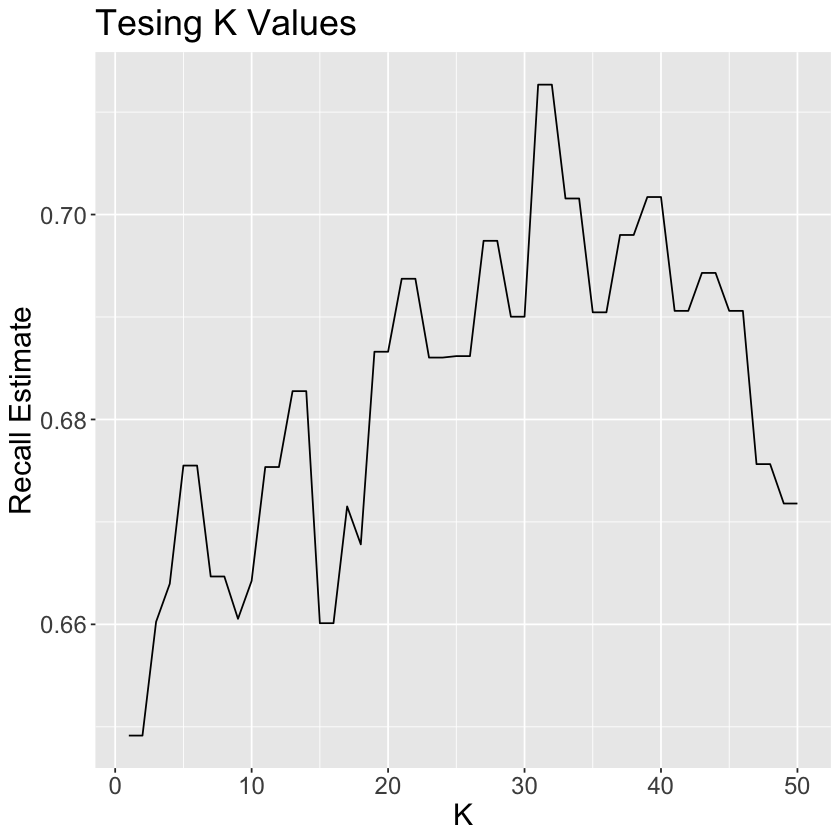

In [154]:
ggplot(knn_results, aes(x = neighbors, y = accuracy)) +
    geom_line() + 
    labs(x = "K", y = "Recall Estimate", title = "Tesing K Values") +
    theme(text = element_text(size = 18))

In [155]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(dementia_recipe) |>
    add_model(knn_spec) |>
    fit(data = dementia_train)

knn_fit

== Workflow [trained] ==========================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor ----------------------------------------------------------------
2 Recipe Steps

* step_mutate()
* step_normalize()

-- Model -----------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(31,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3022388
Best kernel: rectangular
Best k: 31

In [156]:
predict(knn_fit, tibble(Age = 70, nWBV = 0.75, HighlyEducated = 1),
        type = "prob")

.pred_FALSE,.pred_TRUE
<dbl>,<dbl>
0.516129,0.483871


In [157]:
dementia_predictions <- predict(knn_fit, dementia_test, type = "prob") |>
    bind_cols(dementia_test) |>
    mutate(.pred_class = as_factor(if_else(.pred_TRUE > 0.45, "TRUE", "FALSE")))

dementia_predictions |> pull(Dementia) |> levels()

[1] "FALSE" "TRUE"

In [158]:

dementia_predictions |>
    metrics(truth = Dementia, estimate = .pred_class) |>
    filter(.metric == "accuracy")

dementia_predictions |>
    recall(truth = Dementia, estimate = .pred_class, event_level = "second")

dementia_predictions |>
    precision(truth = Dementia, estimate = .pred_class, event_level = "second")


dementia_predictions |>
    conf_mat(truth = Dementia, estimate = .pred_class)

head(dementia_predictions)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7555556


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8108108


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6666667


          Truth
Prediction FALSE TRUE
     FALSE    38    7
     TRUE     15   30

.pred_FALSE,.pred_TRUE,Sex,Age,SES,CDR,nWBV,EducationLevel,Dementia,HighlyEducated,.pred_class
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<lgl>,<fct>
0.7419355,0.2580645,M,69,2,0.5,0.791,2,TRUE,FALSE,FALSE
0.6774194,0.3225806,F,80,2,0.0,0.738,4,FALSE,FALSE,FALSE
0.3870968,0.6129032,F,85,4,0.0,0.710,2,FALSE,FALSE,TRUE
0.8064516,0.1935484,F,64,3,0.0,0.796,4,FALSE,FALSE,FALSE
0.6451613,0.3548387,F,73,1,0.0,0.768,4,FALSE,FALSE,FALSE
0.5806452,0.4193548,F,70,3,0.0,0.766,5,FALSE,TRUE,FALSE


In [159]:
knn_majority_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 283) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_majority_fit <- workflow() |>
    add_recipe(dementia_recipe) |>
    add_model(knn_majority_spec) |>
    fit(data = dementia_train)

knn_majority_fit

Warning message:
"! 283 samples were requested but there were 268 rows in the data.
i 263 samples will be used."


== Workflow [trained] ==========================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor ----------------------------------------------------------------
2 Recipe Steps

* step_mutate()
* step_normalize()

-- Model -----------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(283,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4067164
Best kernel: rectangular
Best k: 263

In [160]:
dementia_predictions_majority <- predict(knn_majority_fit, dementia_test) |>
    bind_cols(dementia_test)

dementia_predictions_majority |>
    metrics(truth = Dementia, estimate = .pred_class) |>
    filter(.metric == "accuracy")

dementia_predictions_majority |>
    conf_mat(truth = Dementia, estimate = .pred_class)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5888889


          Truth
Prediction FALSE TRUE
     FALSE    53   37
     TRUE      0    0

In [161]:
saveRDS(knn_fit, "app/predictor.rds")